In [1]:
num_epochs_base = 700
lr = 0.001
num_hidden = 16

Number of features: 500
Number of classes: 3
Epoch 1, Loss: 1.0986, Train Acc: 0.2500
Val Acc: 0.2760
Epoch 2, Loss: 1.0982, Train Acc: 0.3500
Val Acc: 0.3360
Epoch 3, Loss: 1.0975, Train Acc: 0.3167
Val Acc: 0.3740
Epoch 4, Loss: 1.0955, Train Acc: 0.4500
Val Acc: 0.4320
Epoch 5, Loss: 1.0952, Train Acc: 0.5000
Val Acc: 0.4760
Epoch 6, Loss: 1.0946, Train Acc: 0.5333
Val Acc: 0.5240
Epoch 7, Loss: 1.0945, Train Acc: 0.5000
Val Acc: 0.5540
Epoch 8, Loss: 1.0930, Train Acc: 0.6000
Val Acc: 0.5760
Epoch 9, Loss: 1.0909, Train Acc: 0.7167
Val Acc: 0.5860
Epoch 10, Loss: 1.0929, Train Acc: 0.6333
Val Acc: 0.6240
Epoch 11, Loss: 1.0920, Train Acc: 0.5667
Val Acc: 0.6360
Epoch 12, Loss: 1.0888, Train Acc: 0.6667
Val Acc: 0.6440
Epoch 13, Loss: 1.0899, Train Acc: 0.7000
Val Acc: 0.6500
Epoch 14, Loss: 1.0901, Train Acc: 0.6833
Val Acc: 0.6560
Epoch 15, Loss: 1.0903, Train Acc: 0.6500
Val Acc: 0.6580
Epoch 16, Loss: 1.0878, Train Acc: 0.6667
Val Acc: 0.6620
Epoch 17, Loss: 1.0872, Train Acc: 0

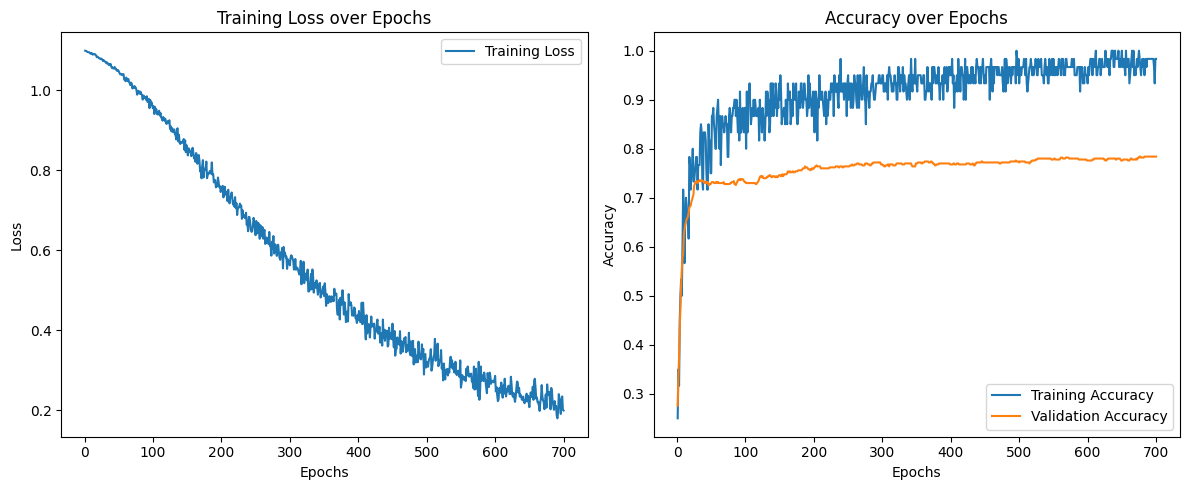

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load the Pubmed dataset
path = './data/Pubmed'
transform = T.Compose([T.NormalizeFeatures()])
dataset = Planetoid(path, name='Pubmed', transform=transform)

# Extract the dataset details
data = dataset[0]
num_features = dataset.num_features
num_classes = dataset.num_classes

print(f'Number of features: {num_features}')
print(f'Number of classes: {num_classes}')

# Initialize the DataLoader
train_loader = DataLoader([data], batch_size=1, shuffle=True)
val_loader = DataLoader([data], batch_size=1, shuffle=False)


# Training and validation functions
def train(model, optimizer, train_loader, device, epoch, distillate=False, teacher=None):
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[dataset.train_mask], data.y[dataset.train_mask])
        ##############################################################################################
        if distillate and teacher is not None:
            with torch.no_grad():
                teacher_out = teacher(data)
            loss += F.mse_loss(out[dataset.train_mask], teacher_out[dataset.train_mask])
        ##############################################################################################
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pred = out[dataset.train_mask].argmax(dim=1)
        correct += pred.eq(data.y[dataset.train_mask]).sum().item()
    train_acc = correct / dataset.train_mask.sum().item()
    print(f'Epoch {epoch}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}')
    return total_loss / len(train_loader.dataset), train_acc

def validate(model, val_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            pred = out[dataset.val_mask].argmax(dim=1)
            correct += pred.eq(data.y[dataset.val_mask]).sum().item()
    val_acc = correct / dataset.val_mask.sum().item()
    print(f'Val Acc: {val_acc:.4f}')
    return val_acc

# Initialize the model and optimizer for Stage 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = GCN(num_features, num_hidden, num_classes).to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr, weight_decay=1e-5)

# Training the base model for 200 epochs
train_losses = []
train_accuracies = []
val_accuracies = []

epochs = range(1, num_epochs_base+1)

for epoch in epochs:
    loss, train_acc = train(base_model, optimizer, train_loader, device, epoch)
    val_acc = validate(base_model, val_loader, device)
    train_losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting the training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Stage 1: Real-valued and Real-weighted Network

In [3]:
train_losses1 = []
train_accuracies1 = []
val_accuracies1 = []
# Define the student model for Stage 1 (replace quantization with tanh)
class StudentGCNStage1(GCN):
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.tanh(x)  # Use tanh instead of ReLU
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the student model and optimizer for Stage 1
student_stage1 = StudentGCNStage1(num_features, num_hidden, num_classes).to(device)
student_stage1.load_state_dict(base_model.state_dict())  # Distill weights from base model
optimizer_stage1 = torch.optim.Adam(student_stage1.parameters(), lr=lr, weight_decay=1e-5)

# Training the student model for Stage 1
for epoch in epochs:
    loss, train_acc = train(student_stage1, optimizer_stage1, train_loader, device, epoch, distillate=True, teacher=base_model)
    val_acc = validate(student_stage1, val_loader, device)
    train_losses1.append(loss)
    train_accuracies1.append(train_acc)
    val_accuracies1.append(val_acc)
print(len(train_losses1))

Epoch 1, Loss: 0.5519, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 2, Loss: 0.4943, Train Acc: 1.0000
Val Acc: 0.7820
Epoch 3, Loss: 0.5833, Train Acc: 0.9667
Val Acc: 0.7840
Epoch 4, Loss: 0.5678, Train Acc: 0.9833
Val Acc: 0.7840
Epoch 5, Loss: 0.5306, Train Acc: 0.9667
Val Acc: 0.7840
Epoch 6, Loss: 0.7041, Train Acc: 1.0000
Val Acc: 0.7820
Epoch 7, Loss: 0.5644, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 8, Loss: 0.6320, Train Acc: 0.9667
Val Acc: 0.7820
Epoch 9, Loss: 0.5559, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 10, Loss: 0.5407, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 11, Loss: 0.6597, Train Acc: 0.9667
Val Acc: 0.7820
Epoch 12, Loss: 0.5274, Train Acc: 0.9500
Val Acc: 0.7820
Epoch 13, Loss: 0.5000, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 14, Loss: 0.5897, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 15, Loss: 0.4833, Train Acc: 1.0000
Val Acc: 0.7820
Epoch 16, Loss: 0.5901, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 17, Loss: 0.5964, Train Acc: 1.0000
Val Acc: 0.7820
Epoch 18, Loss: 0.5532,

In [4]:
train_losses2 = []
train_accuracies2 = []
val_accuracies2 = []


# Define the student model for Stage 2 (binary activations)
class StudentGCNStage2(GCN):
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = (x > 0).float() * 2 - 1  # Binary activations
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the student model and optimizer for Stage 2
student_stage2 = StudentGCNStage2(num_features, num_hidden, num_classes).to(device)
student_stage2.load_state_dict(student_stage1.state_dict())  # Distill weights from Stage 1 model
optimizer_stage2 = torch.optim.Adam(student_stage2.parameters(), lr=lr*0.25, weight_decay=1e-5)  # Smaller learning rate

# Training the student model for Stage 2
for epoch in epochs:
    loss, train_acc = train(student_stage2, optimizer_stage2, train_loader, device, epoch, distillate=True, teacher=student_stage1)
    val_acc = validate(student_stage2, val_loader, device)
    train_losses2.append(loss)
    train_accuracies2.append(train_acc)
    val_accuracies2.append(val_acc)


Epoch 1, Loss: 181.0212, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 2, Loss: 184.6893, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 3, Loss: 177.3866, Train Acc: 0.9833
Val Acc: 0.7520
Epoch 4, Loss: 174.5751, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 5, Loss: 167.8143, Train Acc: 0.9833
Val Acc: 0.7520
Epoch 6, Loss: 188.8126, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 7, Loss: 177.0220, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 8, Loss: 191.1813, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 9, Loss: 188.5868, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 10, Loss: 182.1859, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 11, Loss: 184.9669, Train Acc: 0.9833
Val Acc: 0.7520
Epoch 12, Loss: 187.6522, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 13, Loss: 184.5770, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 14, Loss: 187.9236, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 15, Loss: 180.7371, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 16, Loss: 179.1204, Train Acc: 1.0000
Val Acc: 0.7520
Epoch 17, Loss: 171.2328, Train Acc: 1.0000
Val A

Epoch 1, Loss: 5.7556, Train Acc: 1.0000
Val Acc: 0.7540
Epoch 2, Loss: 3.2829, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 3, Loss: 3.8208, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 4, Loss: 3.6908, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 5, Loss: 4.1867, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 6, Loss: 4.8657, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 7, Loss: 4.0341, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 8, Loss: 3.8533, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 9, Loss: 4.9118, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 10, Loss: 3.8810, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 11, Loss: 3.5545, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 12, Loss: 4.1464, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 13, Loss: 2.8999, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 14, Loss: 4.7453, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 15, Loss: 3.5896, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 16, Loss: 3.6550, Train Acc: 0.9833
Val Acc: 0.7560
Epoch 17, Loss: 4.4134, Train Acc: 1.0000
Val Acc: 0.7560
Epoch 18, Loss: 4.7098,

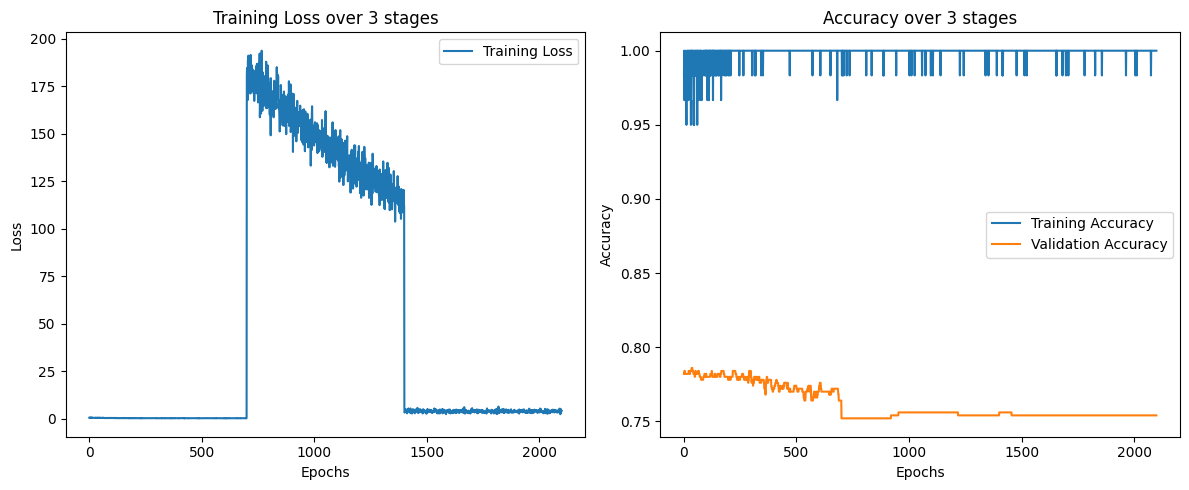

In [5]:
import matplotlib.pyplot as plt


train_losses3 = []
train_accuracies3 = []
val_accuracies3 = []



# Define custom GCNConv layer to handle latent weights
class BinaryGCNConv(GCNConv):
    def __init__(self, in_channels, out_channels):
        super(BinaryGCNConv, self).__init__(in_channels, out_channels)
        self.latent_weight = nn.Parameter(torch.empty(self.out_channels, self.in_channels))
        nn.init.xavier_uniform_(self.latent_weight)  # Initialize weights explicitly

    def forward(self, x, edge_index, edge_weight=None):
        weight_bin = (self.latent_weight > 0).float() * 2 - 1
        self.weight = nn.Parameter(weight_bin)  # Assign the binary weights to self.weight
        return super(BinaryGCNConv, self).forward(x, edge_index, edge_weight)  # Call the parent forward method

    def message(self, x_j, edge_weight):
        if edge_weight is None:
            return x_j
        else:
            return edge_weight.view(-1, 1) * x_j


# Define the custom GCN model with binary weights
class BinaryGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(BinaryGCN, self).__init__()
        self.conv1 = BinaryGCNConv(in_channels, hidden_channels)
        self.conv2 = BinaryGCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = (x > 0).float() * 2 - 1  # Binary activations
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)







# Initialize the student model and optimizer for Stage 3
#student_stage3 = BinaryGCN(num_features, num_hidden, num_classes).to(device)
#student_stage3.load_state_dict(student_stage2.state_dict())  # Distill weights from Stage 2 model
# Initialize the student model for Stage 3
student_stage3 = BinaryGCN(num_features, num_hidden, num_classes).to(device)

# Load the state dictionary from student_stage2 (default weights)
state_dict = student_stage2.state_dict()
student_stage3.load_state_dict(state_dict, strict=False)  # Allow mismatched keys

# Manually update latent_weight for each BinaryGCNConv layer
with torch.no_grad():
    student_stage3.conv1.latent_weight.copy_(student_stage3.conv1.lin.weight.clone().detach())
    student_stage3.conv2.latent_weight.copy_(student_stage3.conv2.lin.weight.clone().detach())






optimizer_stage3 = torch.optim.Adam(student_stage3.parameters(), lr=lr*0.25, weight_decay=0)  # No weight decay

# Training the student model for Stage 3
for epoch in epochs:
    loss, train_acc = train(student_stage3, optimizer_stage3, train_loader, device, epoch, distillate=True, teacher=student_stage2)
    val_acc = validate(student_stage3, val_loader, device)
    train_losses3.append(loss)
    train_accuracies3.append(train_acc)
    val_accuracies3.append(val_acc)





# Combine all epochs into one list
total_epochs = 3 * num_epochs_base
print(len(train_losses1))
print(len(train_losses2))
print(len(train_losses3))
print(len(train_losses))
# Ensure lengths of the lists match
train_losses = train_losses1 + train_losses2 + train_losses3
train_accuracies = train_accuracies1 + train_accuracies2 + train_accuracies3
val_accuracies = val_accuracies1 + val_accuracies2 + val_accuracies3

plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over 3 stages')
plt.legend()

# Plot the accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over 3 stages')
plt.legend()

plt.tight_layout()
plt.show()


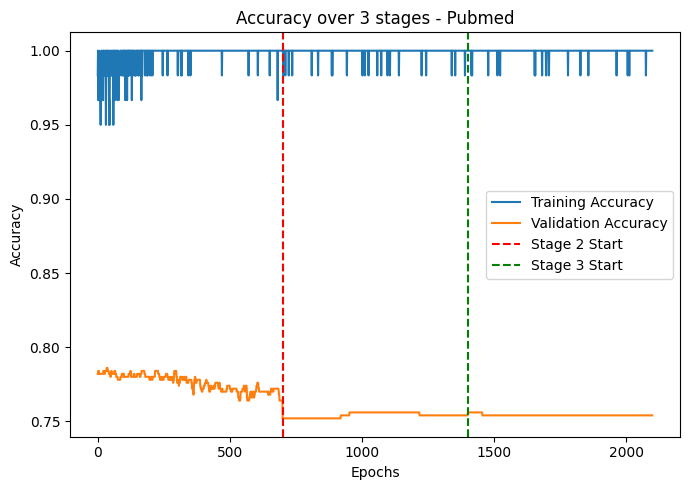

In [6]:
plt.figure(figsize=(7, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axvline(x=700, color='r', linestyle='--', label='Stage 2 Start')
plt.axvline(x=1400, color='g', linestyle='--', label='Stage 3 Start')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over 3 stages - Pubmed')
plt.legend()

plt.tight_layout()
plt.savefig("test_acc_3stage_withoutReAct.png")